# <center>A Data Mining Approach to NHL Salary Prediction </center> 
<center>SENG 474</center>
<center>Fall 2018</center>
<center>Jonathan Healy (V00845624)</center>
<center>Carson Reid (V00856719)</center>

## Table of Contents
1. [Introduction](#introduction)
2. [Data Preprocessing](#preprocessing)
<br>2.1 [Data Retrieval](#retrieval)
<br>2.2 [Training and Testing Data Set Construction](#construction)
3. [Data Mining](#mining)
<br>3.1 [Data Mining Algorithms](#dminealgs)
<br>&nbsp;&nbsp;&nbsp;&nbsp;3.1.1 [Decision Tree Regressor](#dectree)
<br>&nbsp;&nbsp;&nbsp;&nbsp;3.1.2 [Decision Tree Regressor with Max Leaf Nodes](#maxleaf)
<br>&nbsp;&nbsp;&nbsp;&nbsp;3.1.3 [Random Forest](#forest)
<br>&nbsp;&nbsp;&nbsp;&nbsp;3.1.4 [Decision Tree Regressor with XGBoost](#xgboost)
4. [Evaluation](#eval)
5. [Conclusion](#conclusion)
6. [References](#refs)


## 1. Introduction <a name="introduction"/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In the NHL, salaries can range from a few hundred thousand to upwards of ten million dollars. With the salary cap changing every year and players values always changing it can be very useful to be able to predict a player’s contribution to a team’s total salary. Salaries are relatively consistent with the general skill of a player, but there is no formula to compute a player’s salary. To call a player good or bad is almost always a subjective statement, and with this report we look to find out what really makes a good player objectively and how those good player metrics contribute to their salary.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We are basing our calculations purely off of recorded statistics that we can perform calculations on, so that numerical analytical algorithms can be run. The calculation of a player’s value on a certain team with certain teammates that have unique synergies on and off the ice is such an incalculable metric we are choosing to consider it noise in our data. 

## 2. Data Preprocessing <a name="preprocessing"/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The purpose of data preprocessing is to extract data from various sources and convert it into a useful format for analysis. To complete this process we followed these steps:<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1. <b>Data Retrieval:</b> Fetching the Excel files from our online source.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2. <b>Training and Testing data set construction:</b> Generating output CSV and ARFF files to use for Python machine learning libraries.

### 2.1 Data Retrieval <a name="retrieval"/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Words words words getting the CSVs from the website maybe a bit on credibility

### 2.2 Training and Testing Data Set Construction <a name="construction"/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For our first run of regression we have chosen to use what we think to be valuable characteristics of a good hockey player as a thought experiment. These statistics/features are listed below, with a note of the particular aspect/metric of a good player that they contribute to.

| Statistic/Feature | Description | Player Aspect |
|:--- |:---:|---:|
|Age|The age of the player|Individual Skill|
|G|Goals scored by the player in one season|Individual Skill|
|A|Assists attributed to the player in one season|Team Contribution|
|PTS|Total goals plus assists from the player in one season|Individual Skill|
|Shifts|Total number of times the player went on and came off the ice in one season|Team Contribution|
|+/-|The total goals scored for while the player was on the ice minus the total goals scored against while the player was on the ice|Team Contribution+Individual Skill|


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Age: Our rationale behind these features starts with the age of the player. If a player is nearing the end of their career they are more likely to be injured, more likely to retire, and more likely to be slowing down in their scoring capability.<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Goals: The goals scored by a player is often a very useful metric in showing their individual skill, since scoring is the only metric in hockey for determining the winner. The assists attributed to a player are another good metric for determining team contribution. <br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Assists: The ability to accurately pass the puck in a potential scoring situation is difficult to do under pressure and not be selfish when teammates have scoring opportunities all season long shows skill and restraint. <br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Points: The total points of a player is often a more useful comparison tool than comparing goals vs goals and assists vs assists, if a player is on a very high goal-scoring line all season with goals being shared among the other linemates their individual goals or assists might be skewed to one side since they are sharing goals. <br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Shifts: The number of shifts a player has showcases how much their team would like them to be on the ice, and given that teams would like to win games it makes sense that they would put the better players on the ice as much as possible. There is also another hidden metric in this statistic, power play and short handed shifts. Good players will often be on the power play or penalty kill while weaker players stay off the ice to increase the likelihood that penalties will be killed successfully or goals scored on the power play. <br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;+/-: The final metric we chose was plus/minus which is a measure of both individual skill and team contribution. The ability of a player to score goals and contribute to other players scoring goals is important, but being able to prevent goals at your own end of the ice is very important too. This metric is used to generalize both a player’s offensive and defensive capabilities.
<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;All of these listed features were readily available in our data, all that was required was turning an Excel sheet (.xls) into a Attribute-Relation File Format file (.arff) for WEKA and comma-separated values (.csv) file for Python machine learning libraries to use. \*\*\*\*I don’t know what exactly you did to the data I’ll need you to fill in this section or give me some info for it\*\*\*\*


## 3. Data Mining <a name="mining"/>
### 3.1 Data Mining Algorithms
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For our project we decided to use the features outlined in section 3.2 for our first run of regression. The algorithms we used with these features are the following:

### 3.1.1 Decision Tree Regressor <a name="dectree"/>
The following code uses the scikit-learn Python library to generate a decision tree with the features being the ones outlined in section 2.2.

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [2]:
nhl_file_path = 'nhl_data.csv'
nhl_data = pd.read_csv(nhl_file_path)
nhl_data.dropna(axis=0, subset=['Salary'], inplace=True)

In [3]:
# dropna drops missing values (think of na as "not available")
nhl_data = nhl_data.dropna(axis=0)

In [4]:
y = nhl_data.Salary

In [5]:
nhl_features = ['Age', 'G', 'A', 'PTS', '+/-', 'Shifts']

In [6]:
X = nhl_data[nhl_features]

In [7]:
# Define model. Specify a number for random_state to ensure same results each run
nhl_model = DecisionTreeRegressor(random_state=0)

The following code computes a mean absolute error on a random subset of our training data using the decision tree regressor model’s output. 

In [8]:
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we run this script.
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
nhl_model.fit(train_X, train_y)
val_predictions = nhl_model.predict(val_X)
print(mean_absolute_error(val_y, val_predictions))

3047222.222222222


The result of this code shows the mean absolute error is approximately 3.04 million when this classifier is run on a random subset of our training data. Given that salaries are mainly in the range of 500k-10m, this is a poor result.

### 3.1.2 Decision Tree Regressor using Max Leaf Nodes <a name="maxleaf"/>
The following code uses the scikit-learn Python library to generate a decision tree with 5, 50, 500, and 5000 max leaf nodes and the features being the ones outlined in section 2.2.

In [9]:
# underfitting/ overfitting
# compore mae scores from different value for max leaf nodes
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

The following code computes a mean absolute error on a random subset of our training data using the decision tree regressor with max leaf nodes model’s output. 

In [10]:
# compare MAE with differing values of max_leaf_nodes
candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]

for max_leaf_nodes in [5, 50, 500, 5000]:
    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, my_mae))

Max leaf nodes: 5  		 Mean Absolute Error:  2730634
Max leaf nodes: 50  		 Mean Absolute Error:  2569444
Max leaf nodes: 500  		 Mean Absolute Error:  2569444
Max leaf nodes: 5000  		 Mean Absolute Error:  2569444


The result of this code shows the best mean absolute error with different amounts of max leaf nodes is 2,569,444 when this classifier is run on a random subset of our training data. Given that salaries are mainly in the range of 500k-10m, this is again a poor result. 

In [11]:
scores = {leaf_size: get_mae(leaf_size, train_X, val_X, train_y, val_y) for leaf_size in candidate_max_leaf_nodes}
best_tree_size = min(scores, key=scores.get)

In [12]:
# Fit the model with best_tree_size. Fill in argument to make optimal size
final_model = DecisionTreeRegressor(max_leaf_nodes=best_tree_size, random_state=0)

# fit the final model
final_model.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=25, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [13]:
# get predicted prices on validation data
val_predictions = final_model.predict(val_X)
print(mean_absolute_error(val_y, val_predictions))

78888.88888888889


### 3.1.3 Random Forest <a name="forest"/>
The following code uses the scikit-learn Python library to generate a random forest based classifier with the subsets of features being selected from the features outlined in section 2.2.

In [14]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(random_state=0)
forest_model.fit(train_X, train_y)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

The following code computes a mean absolute error on a random subset of our training data using the random forest decision tree regressor model’s output. 

In [15]:
nhl_preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, nhl_preds))

2508611.111111111


The result of this code shows the best mean absolute error with X trees is approximately 2.5 million when this classifier is run on a random subset of our training data. This is again a poor result but a slight improvement over the last two methods. 

### 3.1.4 Decision Tree Regressor with XGBoost <a name="xgboost"/>
The following uses the scikit-learn Python library to generate a decision tree regressor from the gradient boost algorithm using the features outlined in section 2.2.

In [16]:
from sklearn.preprocessing import Imputer
from xgboost import XGBRegressor

In [26]:
data = pd.read_csv('nhl_data.csv')
data.dropna(axis=0, subset=['Salary'], inplace=True)

y = data.Salary
nhl_features = ['Age', 'G', 'A', 'PTS', '+/-', 'Shifts']

X = data[nhl_features]
data = data.dropna(axis=0)
train_X, test_X, train_y, test_y = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.25)

my_imputer = Imputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [27]:
my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [28]:
# make predictions
predictions = my_model.predict(test_X)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 1079072.399321267


### XG Boost with n-estimators

In [29]:
# n-estimators = how many times to go through the model size above
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [30]:
predictions = my_model.predict(test_X)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 1062284.678167421


### XG Boost with learning rate and n-estimators

In [31]:
# learning - rate
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [32]:
predictions = my_model.predict(test_X)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 1059631.4165723983


### XG Boost with Cross-Validation

In [33]:
import xgboost as xgb
# k-fold cross validation (3 fold model here)
data_dmatrix = xgb.DMatrix(data=X,label=y)

params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

In [34]:
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                  num_boost_round=50,early_stopping_rounds=10,metrics="mae", as_pandas=True, seed=123)
#cv_results.head()
print((cv_results["test-mae-mean"]).tail(1))

[09:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[09:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[09:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[09:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[09:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[09:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[09:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[09:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

## Visualization with Partial Dependence Plots and Decision Tree

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from pdpbox import pdp, get_dataset, info_plots
from sklearn import tree
import graphviz

In [36]:
data = pd.read_csv('nhl_data.csv')
y = (data['Salary'] > 950000)  # Convert from string "Yes"/"No" to binary
feature_names = ['Age', 'G', 'A', 'PTS', '+/-']
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=3, min_samples_split=5).fit(train_X, train_y)

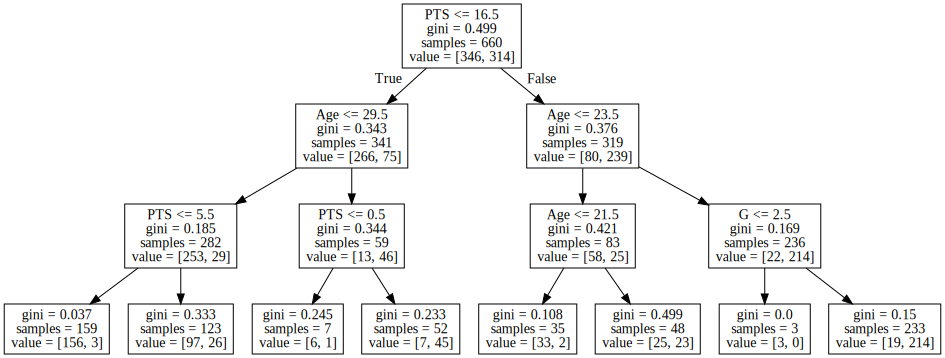

In [37]:
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=feature_names)
graphviz.Source(tree_graph)

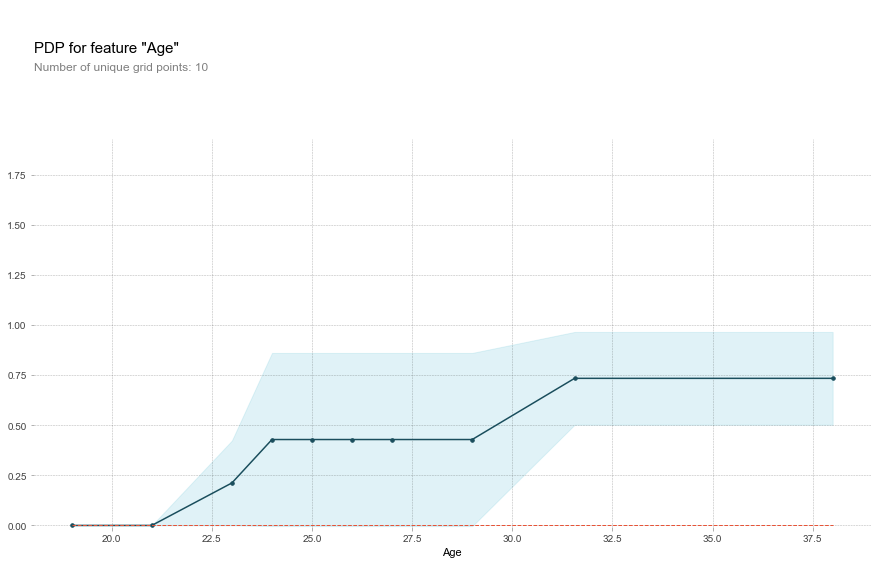

In [38]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature='Age')

# plot it
pdp.pdp_plot(pdp_goals, 'Age')
plt.show()

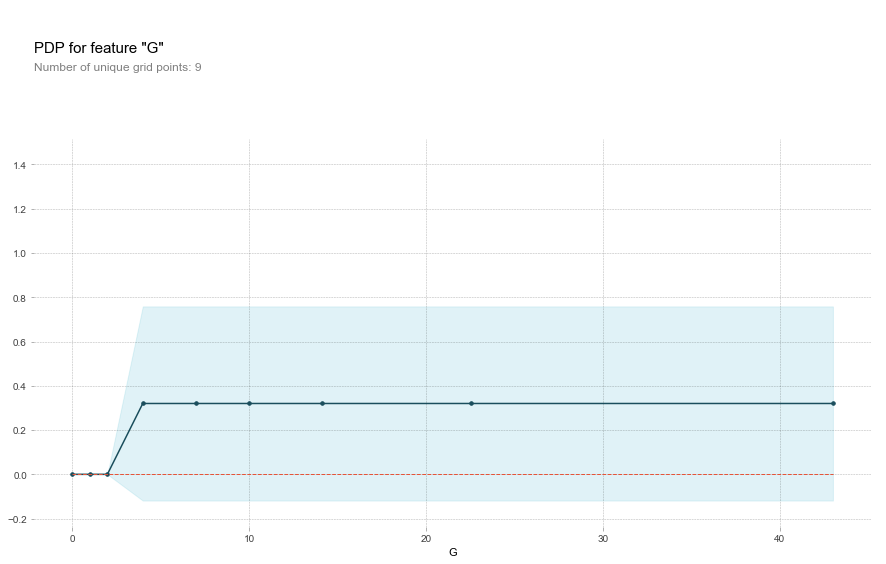

In [39]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature='G')

# plot it
pdp.pdp_plot(pdp_goals, 'G')
plt.show()

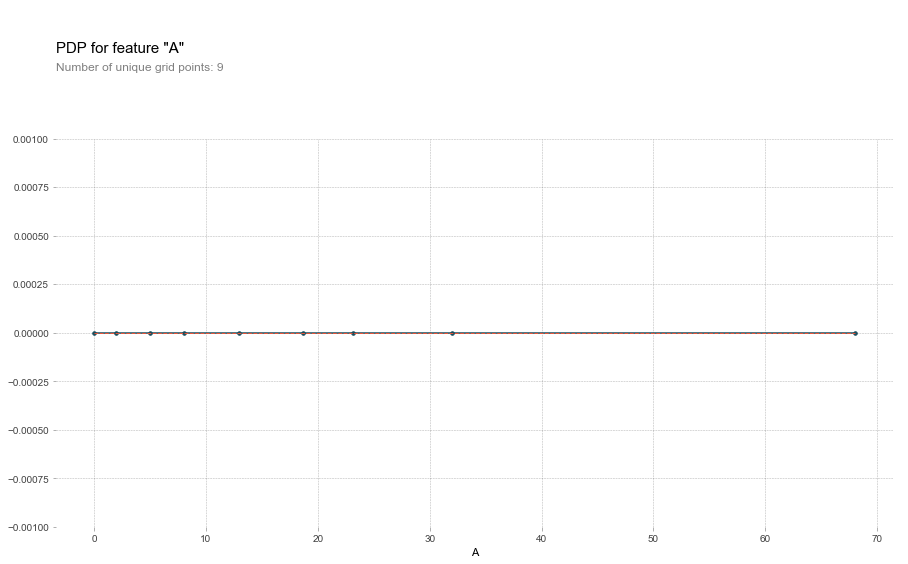

In [40]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature='A')

# plot it
pdp.pdp_plot(pdp_goals, 'A')
plt.show()

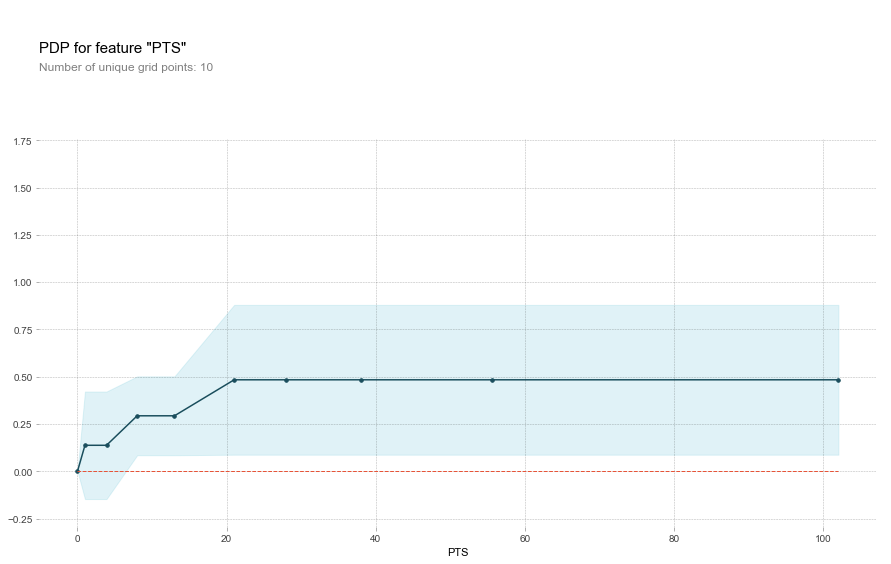

In [41]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature='PTS')

# plot it
pdp.pdp_plot(pdp_goals, 'PTS')
plt.show()

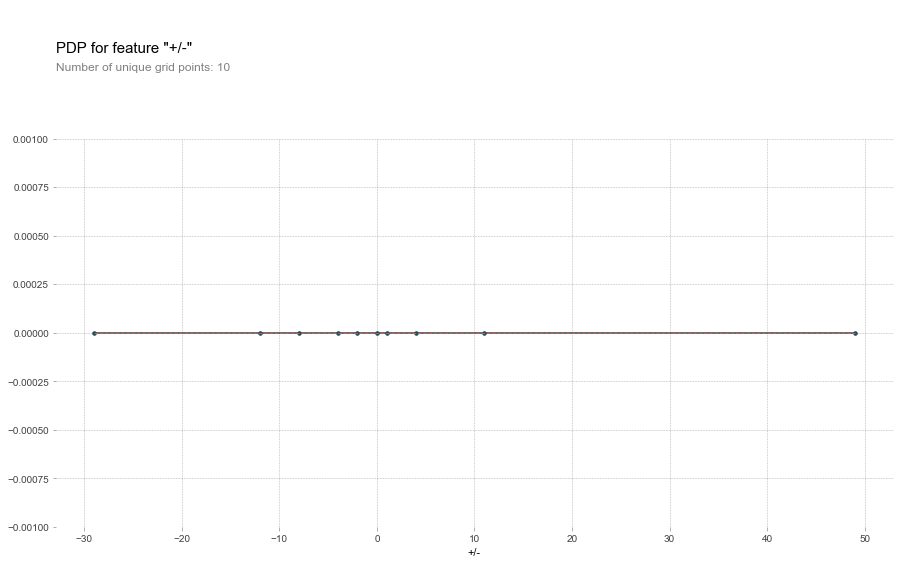

In [42]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature='+/-')

# plot it
pdp.pdp_plot(pdp_goals, '+/-')
plt.show()

## Feature Selection with XG Boost

In [43]:
# gradient boosting with XG Boost
# https://www.datacamp.com/community/tutorials/xgboost-in-python
import xgboost as xgb

In [44]:
data = pd.read_csv('nhl_data.csv')
y = data.Salary
# extended feature list --- could add to this
nhl_features = ['Ovrl', 'Age', 'PTS/GP', 'TOI/GP', 'TOff/60', 'C-PTS', 'PTS', 'Star', 'G', 'A', 'iSF',
                'iHF', 'Over', 'CriG', 'xGF', 'CF', 'SF', 'FF']
X = data[nhl_features]
data = data.dropna(axis=0)

In [45]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [47]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

In [48]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [49]:
print("Mean Absolute Error : " + str(mean_absolute_error(preds, y_test)))

Mean Absolute Error : 710844.9463276836


In [54]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10, verbose_eval=50)

[09:47:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[09:47:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[09:47:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[09:47:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[09:47:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[09:47:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[09:47:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[09:47:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[09:47:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_

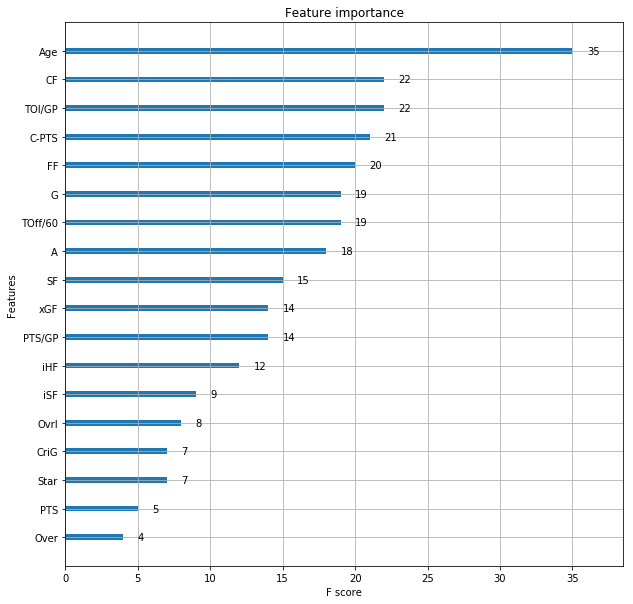

In [55]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

## Decision Tree Regressor (improved features)

In [56]:
nhl_file_path = 'nhl_data.csv'
nhl_data = pd.read_csv(nhl_file_path)
nhl_data.dropna(axis=0, subset=['Salary'], inplace=True)

In [57]:
# dropna drops missing values (think of na as "not available")
nhl_data = nhl_data.dropna(axis=0)
y = nhl_data.Salary
nhl_features = ['Age', 'CF', 'A', 'C-PTS', 'TOI/GP', 'xGF', 'TOff/60']
X = nhl_data[nhl_features]
# Define model. Specify a number for random_state to ensure same results each run
nhl_model = DecisionTreeRegressor(random_state=0)

In [58]:
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we run this script.
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
nhl_model.fit(train_X, train_y)
val_predictions = nhl_model.predict(val_X)
print(mean_absolute_error(val_y, val_predictions))

1963888.888888889


Mean absolute error before improved features = 3047222
After improved features = 1963888

## Decision Tree Regressor with Max Leaf Nodes (improved features)

In [59]:
# underfitting/ overfitting
# compore mae scores from different value for max leaf nodes
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

In [60]:
# compare MAE with differing values of max_leaf_nodes
candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]

for max_leaf_nodes in [5, 50, 500, 5000]:
    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, my_mae))

Max leaf nodes: 5  		 Mean Absolute Error:  2021141
Max leaf nodes: 50  		 Mean Absolute Error:  1908333
Max leaf nodes: 500  		 Mean Absolute Error:  1908333
Max leaf nodes: 5000  		 Mean Absolute Error:  1908333


In [61]:
scores = {leaf_size: get_mae(leaf_size, train_X, val_X, train_y, val_y) for leaf_size in candidate_max_leaf_nodes}
best_tree_size = min(scores, key=scores.get)

In [62]:
# Fit the model with best_tree_size. Fill in argument to make optimal size
final_model = DecisionTreeRegressor(max_leaf_nodes=best_tree_size, random_state=0)

# fit the final model
final_model.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=25, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [63]:
# get predicted prices on validation data
val_predictions = final_model.predict(val_X)
print(mean_absolute_error(val_y, val_predictions))

25000.0


Mean absolute error before improved features = 78888
After improved features = 25000

## Random Forest (Improved Features)

In [64]:
forest_model = RandomForestRegressor(random_state=0)
forest_model.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [65]:
nhl_preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, nhl_preds))

1898888.888888889


### Decision Tree Regressor with XG Boost (Improved Features)

In [66]:
data = pd.read_csv('nhl_data.csv')
data.dropna(axis=0, subset=['Salary'], inplace=True)

y = data.Salary
nhl_features = ['Age', 'CF', 'A', 'C-PTS', 'TOI/GP', 'xGF', 'TOff/60']

X = data[nhl_features]
data = data.dropna(axis=0)
train_X, test_X, train_y, test_y = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.25)

my_imputer = Imputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

In [67]:
my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [68]:
# make predictions
predictions = my_model.predict(test_X)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 686905.9032805429


### XG Boost with n-estimators and learning rate (improved features)

In [75]:
# learning - rate
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [76]:
predictions = my_model.predict(test_X)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 710444.2607466064


## More Visualization

In [82]:
# https://www.kaggle.com/dansbecker/partial-plots

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

data = pd.read_csv('nhl_data.csv')
#y = data.Salary
y = (data['Salary'] > 950000)  # Convert from string "Yes"/"No" to binary
feature_names = ['Age', 'CF', 'A', 'C-PTS', 'TOI/GP', 'xGF', 'TOff/60']
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

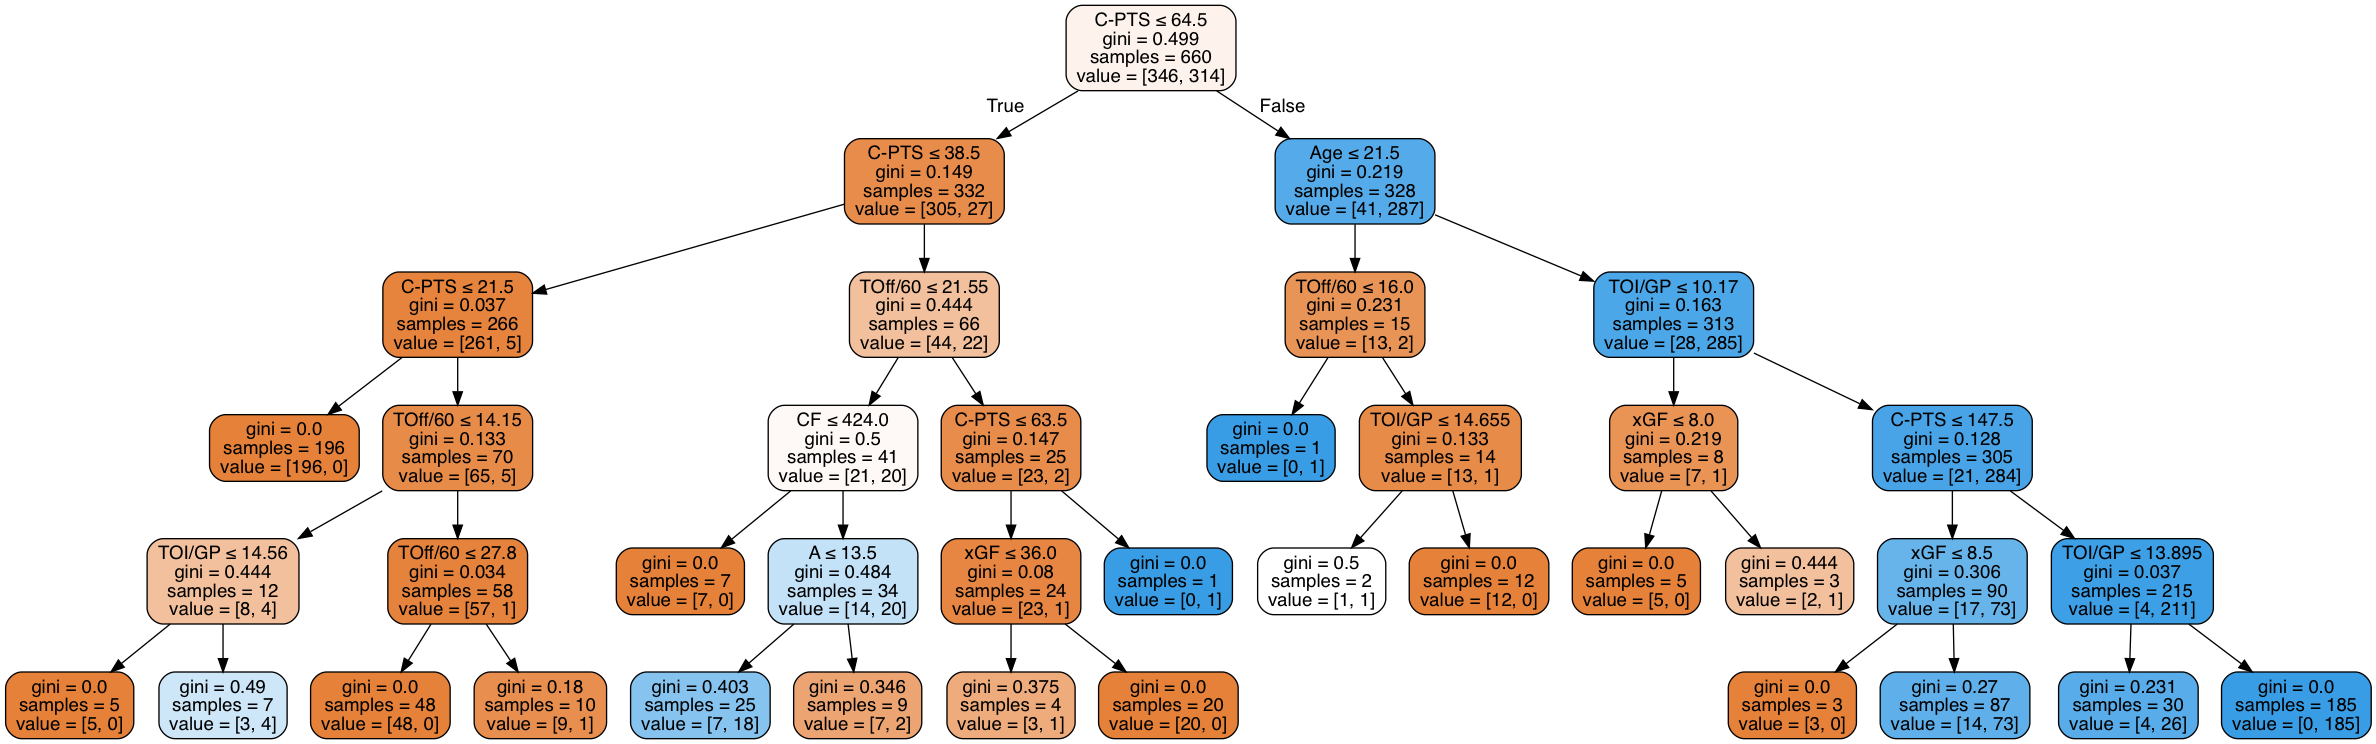

In [83]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(tree_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=feature_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

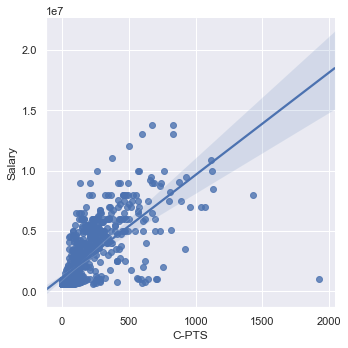

In [96]:
https://elitedatascience.com/python-seaborn-tutorial

import numpy as np; np.random.seed(0)
import seaborn as sns;

df = pd.read_csv('nhl_data.csv')
#uniform_data = np.random.rand(10, 12)
#flights = sns.load_dataset("flights")
#flights = flights.pivot("Age", "CF", "A")
#ax = sns.heatmap(flights, annot=True, fmt="d")
sns.lmplot(x='C-PTS', y='Salary', data=df)

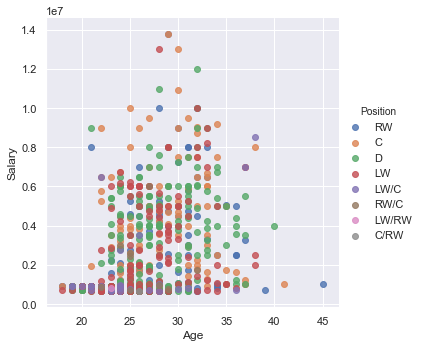

In [101]:
# Scatterplot arguments
sns.lmplot(x='Age', y='Salary', data=df,
           fit_reg=False, # No regression line
           hue='Position')   # Color by evolution stage

In [105]:
#results = df.pivot("Age", "Salary", "Position")
corr = nhl_features.corr()
sns.heatmap(corr)

AttributeError: 'list' object has no attribute 'corr'